In [1]:
import os
import sys
sys.path.append("..")

In [2]:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1" # "1", "2", "3"

# IPL-VAE: Fashion MNIST

In [3]:
import jax
import optax
import distrax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable
from torchvision.datasets import FashionMNIST

import vae
import ipl_vae as linvae

In [4]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [5]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [6]:
root = "/tmp/fashion-mnist"
mnist_train = FashionMNIST(root, download=True, train=True)
mnist_test = FashionMNIST(root, download=True, train=False)

In [7]:
key = jax.random.PRNGKey(314)
key_fa_param, key_sample, key = jax.random.split(key, 3)
key_vae, key_iplvae = jax.random.split(key)

In [8]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

## IPL - VAE

In [9]:
key_ipl, key_init_params = jax.random.split(key_iplvae, 2)

In [10]:
class FADecoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a Factor Analysis (FA) model
    """
    dim_obs: int
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()
    uniform_init: Callable = nn.initializers.uniform()

    
    def setup(self):
        self.b = self.param("b", self.normal_init, (self.dim_obs,))
        self.A = self.param("A", self.normal_init, (self.dim_obs, self.dim_latent))
        # self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs, self.dim_latent))
        self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs,))


    def eval_mean(self, z):
        mean_x = jnp.einsum("...m,dm->...d", z, self.A)+ self.b
        return mean_x
    
    def eval_diag_cov(self, z):
        # logvar_x = jnp.einsum("...m,dm->...d", z, self.logPsi)
        zeros = jnp.zeros((self.dim_obs, self.dim_latent))
        logvar_x = jnp.einsum("...m,dm->...d", z, zeros) + self.logPsi

        return logvar_x


    def __call__(self, z):
        mean_x = self.eval_mean(z)
        logvar_x = self.eval_diag_cov(z)
        
        return mean_x, logvar_x

    
class Decoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a 
    """
    dim_obs: int
    dim_latent: int = 20
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs,))
    
    def eval_diag_cov(self, z):
        # logvar_x = jnp.einsum("...m,dm->...d", z, self.logPsi)
        zeros = jnp.zeros((self.dim_obs, self.dim_latent))
        logvar_x = jnp.einsum("...m,dm->...d", z, zeros) + self.logPsi

        return logvar_x


    @nn.compact
    def __call__(self, z):
        x = nn.Dense(30)(z)
        x = nn.relu(x)
        mean_x = nn.Dense(self.dim_obs, use_bias=True)(x)
        # logvar_x = nn.Dense(self.dim_obs, use_bias=False)(x)
        logvar_x = self.eval_diag_cov(z)
        
        return mean_x, logvar_x

In [11]:
@partial(jax.vmap, in_axes=(None, None, 1), out_axes=1)
def jmp_part (f, primals, tangents):
    """
    Jacobian Matrix Product (JMP) is the product of
    Jacobian Vector Product (JVP).
    
    We assume f: R^L -> R^M. This operation can be
    computed in in O(L^2) time.
    """
    return jax.jvp(f, (primals,), (tangents,))

def jmp(f, primals, tangents):
    fx, jac_mat = jmp_part(f, primals, tangents)
    return fx[:, 0], jac_mat


@partial(jax.jit, static_argnames='dim')
def fill_lower_tri(v, dim):
    """
    Fill a vector with lower triangular (without diagonal)
    values into a square matrix.

    Source: https://github.com/google/jax/discussions/10146
    """
    idx = jnp.tril_indices(dim, k=-1)
    return jnp.zeros((dim, dim), dtype=v.dtype).at[idx].set(v)

In [12]:
Gv = jax.random.normal(key, (784, 50))
Sigmav =  jax.random.normal(key, (50, 50))
Kv = jax.random.normal(key, (50, 784))
Sv = jax.random.normal(key, (784, 784))
 
contraction_S = jnp.einsum_path("im,mk,jk->ij", Gv, Sigmav, Gv, optimize="optimal")
contraction_Sigma = jnp.einsum_path("im,mk,jk->ij", Kv, Sv, Kv, optimize="optimal")

In [13]:
class DiagIPL:
    def __init__(self, prior_mu, prior_Sigma, decoder,
                 n_iterations=1, num_is_samples=13):
        self.prior_mu = prior_mu
        self.prior_Sigma = prior_Sigma
        self.decoder = decoder
        self.num_iterations = n_iterations
        self.dim_obs = decoder.dim_obs
        self.dim_latent = decoder.dim_latent
        self.num_is_samples = num_is_samples


    @partial(jax.jit, static_argnums=(0,))
    def lin_predict(self, mu, Sigma, params):
        m, logPsi = self.decoder.apply(params, mu)
        G = jax.jacfwd(lambda x: self.decoder.apply(params, x)[0])(mu)
        Psi = jnp.exp(logPsi) * jnp.eye(self.dim_obs)
        
        S = jnp.einsum("im,mk,jk->ij", G, Sigma, G,
                       optimize=contraction_S[0])
        S = S + Psi
        C = Sigma @ G.T
        
        return m, S, C

    @partial(jax.jit, static_argnums=(0,))
    def gauss_condition(self, mu_prev, Sigma_prev, y, m, S, C):
        K = jnp.linalg.solve(S, C.T).T
        mu_est = mu_prev + K @ (y - m)

        Sigma_est = jnp.einsum("im,mk,jk->ij", K, S, K,
                               optimize=contraction_Sigma[0])
        Sigma_est = Sigma_prev - Sigma_est
        # Sigma_est = jnp.tril(Sigma_est) + jnp.tril(Sigma_est, k=-1).T
        
        return mu_est, Sigma_est
    
    @partial(jax.jit, static_argnums=(0,))
    def iterate_posterior_step(self, state, y, params):
        """
        Iterate posterior step
        """
        mu, Sigma = state
        m, S, C = self.lin_predict(mu, Sigma, params)
        mu_est, Sigma_est = self.gauss_condition(mu, Sigma, y, m, S, C)
        new_state = (mu_est, Sigma_est)
        return new_state
    
    @partial(jax.jit, static_argnums=(0,))
    def estimate_posterior_params(self, y, params):
        state = (self.prior_mu, self.prior_Sigma)
        ips = partial(self.iterate_posterior_step, params=params)
        
        # lax.scan makes it painfully slow
        # state, _ = jax.lax.scan(ips, state, jnp.ones((self.num_iterations, 1)) * y)

        for it in range(self.num_iterations): 
            state = ips(state, y)    
        post_mu, post_Sigma = state
        
        return post_mu, post_Sigma
    

    @partial(jax.jit, static_argnums=(0,))
    def compute_iwlmm_single(self, key, obs, params):
        mu, Sigma = self.estimate_posterior_params(obs, params)
        dist_posterior_latent = tfd.MultivariateNormalFullCovariance(mu, Sigma)
        dist_prior_latent = tfd.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))

        is_samples = dist_posterior_latent.sample(seed=key, sample_shape=self.num_is_samples)
        
        mean_x, logvar_x = self.decoder.apply(params, is_samples)
        
        # cov_x = jax.vmap(jnp.diag)(jnp.exp(logvar_x / 2))
        # dist_decoder = distrax.MultivariateNormalFullCovariance(mean_x, cov_x)

        cov_x = jnp.exp(logvar_x)
        dist_decoder = tfd.MultivariateNormalDiag(mean_x, cov_x)
        

        log_is = (dist_decoder.log_prob(obs)
                + dist_prior_latent.log_prob(is_samples)
                - dist_posterior_latent.log_prob(is_samples))
        
        return jax.nn.logsumexp(log_is, b=1/self.num_is_samples)

## Run process

In [139]:
dim_latent = 50

In [209]:
batch_init = jnp.ones((1, dim_latent))
decoder = Decoder(dim_obs, dim_latent)

In [210]:
params_decoder = decoder.init(key_init_params, batch_init)

n_iterations = 1
prior_mu, prior_Sigma = jnp.ones(dim_latent), jnp.eye(dim_latent)
ipl_vae = DiagIPL(prior_mu, prior_Sigma, decoder,
                  n_iterations=n_iterations, num_is_samples=50)

learning_rate = 1e-3
# tx = optax.adam(-learning_rate)

tx = optax.chain(
    # optax.clip(1.0),
    optax.adam(-learning_rate),
)


opt_state = tx.init(params_decoder)

In [186]:
def epoch_step(state, xs, gradfn):
    params, opt_state = state
    key, observation = xs
    
    loss, grads = gradfn(key, observation, params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    state = (params, opt_state)
    
    return state, loss

In [187]:
def epoch_step(state, xs, gradfn):
    params, opt_state = state
    key, observation = xs
    loss, grads = gradfn(key, observation, params)    
    
    return grads, loss

def run_epoch(key, params_init, opt_state, observations, gradfn):
    keys = jax.random.split(key, len(observations))
    xs = (keys, observations)
    state = (params_init, opt_state)
    # state, losses = jax.lax.scan(partial(epoch_step, gradfn=gradfn), state, xs)
    grads, losses = jax.vmap(partial(epoch_step, gradfn=gradfn), (None, 0))(state, xs)
    loss = losses.sum()
    grads = jax.tree_map(lambda x: x.mean(axis=0), grads)
    
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params_init, updates)
    state = (params, opt_state)
    
    return state, losses

In [188]:
params_prior = params_decoder

In [189]:
samples_observed = X_train[:]
gradfn = jax.value_and_grad(ipl_vae.compute_iwlmm_single, argnums=-1)
part_epoch = jax.jit(partial(run_epoch, gradfn=gradfn))

In [190]:
%%time
state_final, loss = part_epoch(key, params_prior, opt_state, samples_observed[:100])
params_prior, opt_state = state_final
jax.block_until_ready(loss).sum()

CPU times: user 1min, sys: 12.9 s, total: 1min 13s
Wall time: 6.22 s


DeviceArray(-115071.13, dtype=float32)

In [191]:
samples_batch = X_train.reshape(10, -1, 28 **2)

In [192]:
%%time

loss_hist = []
key_epochs = jax.random.split(key_ipl, 4000)
# gradfn = jax.value_and_grad(ipl_vae.compute_iwlmm_single, argnums=-1)
# part_epoch = jax.jit(partial(run_epoch, gradfn=gradfn))

params_prior = params_decoder
ix = 0
for key in tqdm(key_epochs):
    state_final, loss = part_epoch(key, params_prior, opt_state, samples_batch[0])
    params_prior, opt_state = state_final
    loss = loss.sum().item()
    if jnp.isnan(loss):
        break

    params_decoder = params_prior
        
    ix += 1
    print(f"{loss:.3e}", end="\r")
    loss_hist.append(loss)

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 16 s, sys: 4.79 s, total: 20.8 s
Wall time: 1min 16s


In [194]:
loss_hist[-1]

10199.68359375

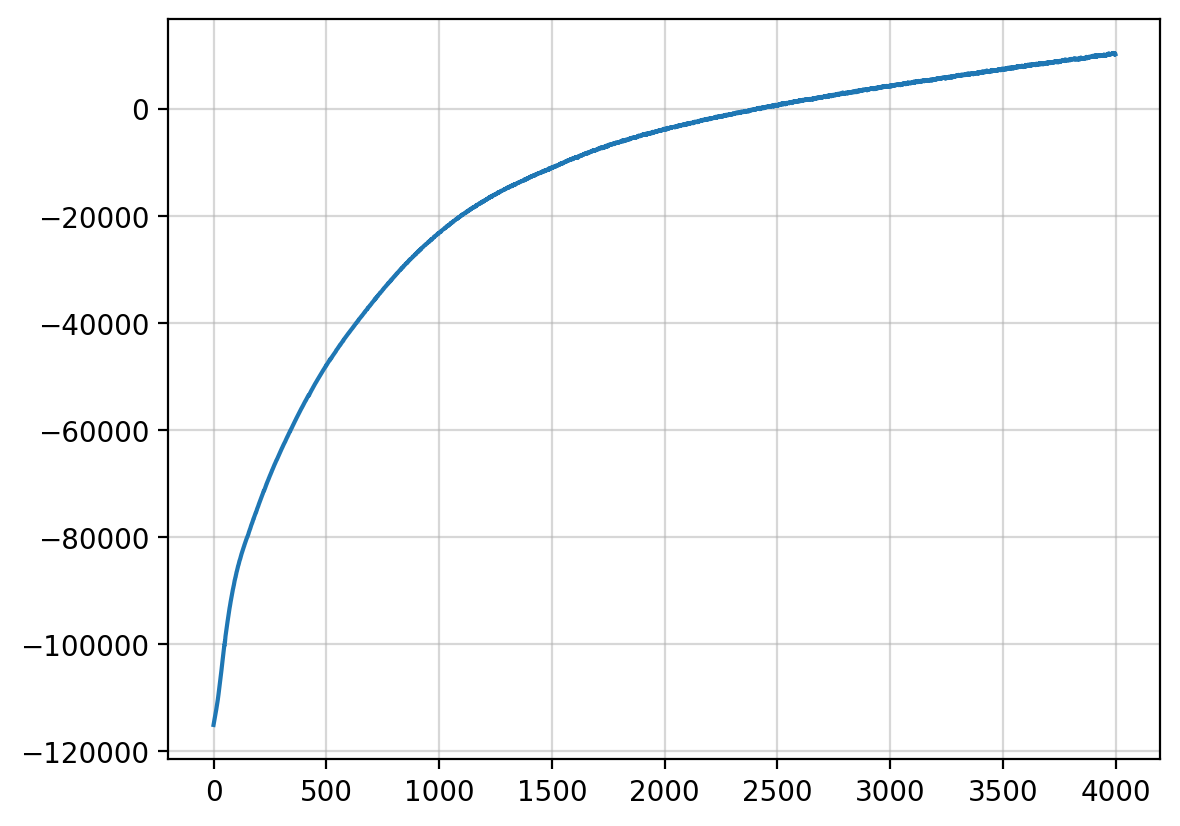

In [193]:
plt.plot(loss_hist)
# plt.plot(hist_mll_vae)
plt.grid(alpha=0.5)

## Mini-batch setting

In [239]:
params_decoder = decoder.init(key_init_params, batch_init)

n_iterations = 1
prior_mu, prior_Sigma = jnp.ones(dim_latent), jnp.eye(dim_latent)
ipl_vae = DiagIPL(prior_mu, prior_Sigma, decoder,
                  n_iterations=n_iterations, num_is_samples=50)

learning_rate = 1e-4
# tx = optax.adam(-learning_rate)

tx = optax.chain(
    # optax.clip(1.0),
    optax.adam(-learning_rate),
)


opt_state = tx.init(params_decoder)

In [240]:
def train_epoch(key, params_init, opt_state, observations, batch_size, gradfn):
    num_samples = len(observations)
    key_batch, keys_vae = jax.random.split(key)
    batch_ixs = vae.get_batch_train_ixs(key_batch, num_samples, batch_size)
    
    num_batches = len(batch_ixs)
    keys_vae = jax.random.split(keys_vae, num_batches)
    
    total_loss = 0
    for key_vae, batch_ix in zip(keys_vae, batch_ixs):
        observations_batch = observations[batch_ix, ...]
        
        keys = jax.random.split(key, len(batch_ix))
        xs = (keys, observations_batch)
        state = (params_init, opt_state)
        
        grads, losses = jax.vmap(partial(epoch_step, gradfn=gradfn), (None, 0))(state, xs)
        loss = losses.sum()
        grads = jax.tree_map(lambda x: x.mean(axis=0), grads)
        
        updates, opt_state = tx.update(grads, opt_state)
        params_init = optax.apply_updates(params_init, updates)
        
        total_loss += loss.sum()
    
    state = (params_init, opt_state)
    return state, total_loss

In [241]:
part_epoch = jax.jit(partial(train_epoch, gradfn=gradfn, batch_size=50))

In [242]:
params_prior = params_decoder

In [243]:
%%time
state_final, loss = part_epoch(key, params_prior, opt_state, samples_observed)
params_prior, opt_state = state_final
jax.block_until_ready(loss).sum()

CPU times: user 3min 3s, sys: 1min 12s, total: 4min 15s
Wall time: 1min 3s


DeviceArray(-1144570.6, dtype=float32)

In [244]:
%%time

loss_hist = []
key_epochs = jax.random.split(key_ipl, 4000)
# gradfn = jax.value_and_grad(ipl_vae.compute_iwlmm_single, argnums=-1)
# part_epoch = jax.jit(partial(run_epoch, gradfn=gradfn))

params_prior = params_decoder
ix = 0
for key in tqdm(key_epochs):
    total_loss = 0

    state_final, loss = part_epoch(key, params_prior, opt_state, samples_observed)
    params_prior, opt_state = state_final
    loss = loss.sum().item()
    if jnp.isnan(loss):
        break

    params_decoder = params_prior
    total_loss += loss
        
    ix += 1
    print(f"{total_loss:.3e}", end="\r")
    loss_hist.append(total_loss)

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 22.9 s, sys: 5.34 s, total: 28.3 s
Wall time: 14min 8s


In [245]:
%store -r hist_mll_vae

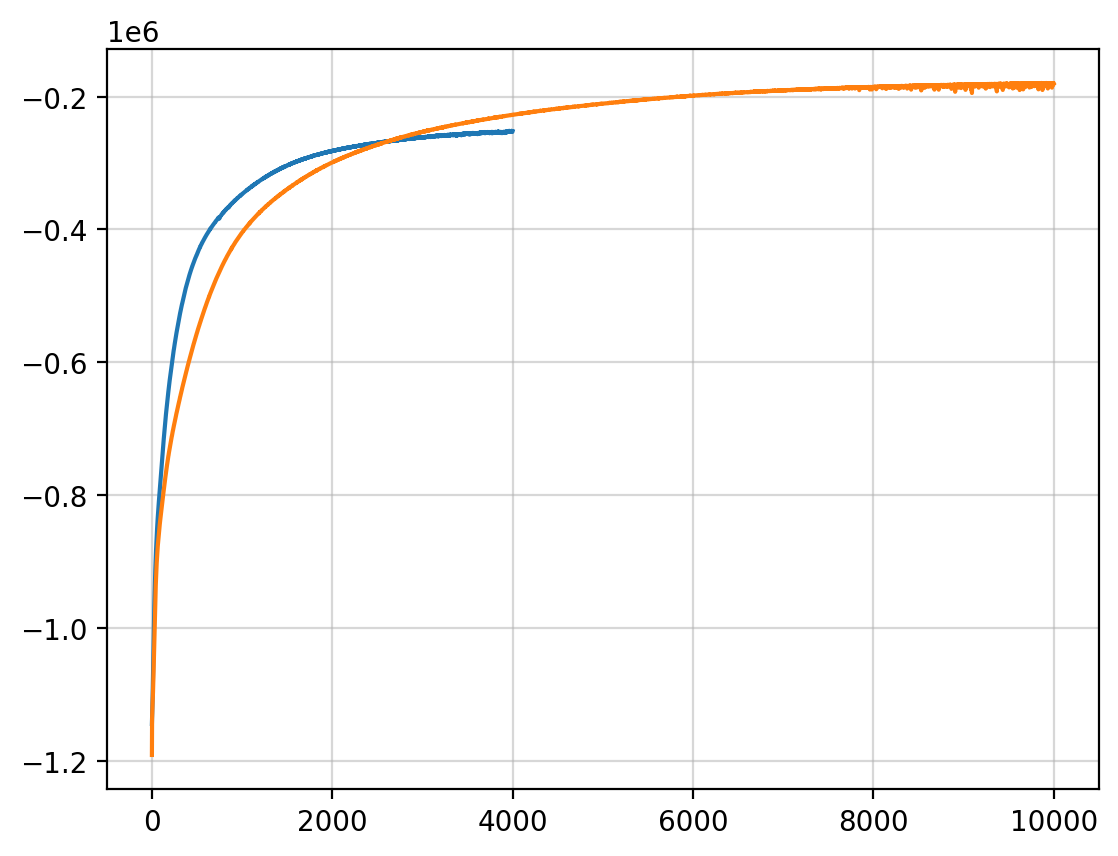

In [246]:
plt.plot(loss_hist)
plt.plot(hist_mll_vae)
plt.grid(alpha=0.5)

## Mini-batch setting (1)

In [304]:
params_decoder = decoder.init(key_init_params, batch_init)

n_iterations = 3
prior_mu, prior_Sigma = jnp.ones(dim_latent), jnp.eye(dim_latent)
ipl_vae = DiagIPL(prior_mu, prior_Sigma, decoder,
                  n_iterations=n_iterations, num_is_samples=50)

learning_rate = 1e-3
# tx = optax.adam(-learning_rate)

tx = optax.chain(
    # optax.clip(1.0),
    optax.adam(-learning_rate),
)


opt_state = tx.init(params_decoder)

In [305]:
gradfn = jax.value_and_grad(ipl_vae.compute_iwlmm_single, argnums=-1)

In [306]:
def train_epoch(key, params_init, opt_state, observations, batch_size, gradfn):
    num_samples = len(observations)
    key_batch, keys_vae = jax.random.split(key)
    batch_ixs = vae.get_batch_train_ixs(key_batch, num_samples, batch_size)
    
    num_batches = len(batch_ixs)
    keys_vae = jax.random.split(keys_vae, num_batches)
    
    total_loss = 0
    for key_vae, batch_ix in zip(keys_vae, batch_ixs):
        observations_batch = observations[batch_ix, ...]
        
        keys = jax.random.split(key, len(batch_ix))
        xs = (keys, observations_batch)
        state = (params_init, opt_state)
        
        grads, losses = jax.vmap(partial(epoch_step, gradfn=gradfn), (None, 0))(state, xs)
        loss = losses.sum()
        grads = jax.tree_map(lambda x: x.mean(axis=0), grads)
        
        updates, opt_state = tx.update(grads, opt_state)
        params_init = optax.apply_updates(params_init, updates)
        
        total_loss += loss.sum()
    
    state = (params_init, opt_state)
    return state, total_loss

In [307]:
part_epoch = jax.jit(partial(train_epoch, gradfn=gradfn, batch_size=10))

In [308]:
params_prior = params_decoder

In [309]:
%%time
state_final, loss = part_epoch(key, params_prior, opt_state, samples_observed)
params_prior, opt_state = state_final
jax.block_until_ready(loss).sum()

CPU times: user 14min 20s, sys: 33.2 s, total: 14min 54s
Wall time: 12min 41s


DeviceArray(-1025904.56, dtype=float32)

In [310]:
%%time

loss_hist = []
key_epochs = jax.random.split(key_ipl, 4000)
# gradfn = jax.value_and_grad(ipl_vae.compute_iwlmm_single, argnums=-1)
# part_epoch = jax.jit(partial(run_epoch, gradfn=gradfn))

params_prior = params_decoder
ix = 0
for key in tqdm(key_epochs):
    total_loss = 0

    state_final, loss = part_epoch(key, params_prior, opt_state, samples_observed)
    params_prior, opt_state = state_final
    loss = loss.sum().item()
    if jnp.isnan(loss):
        break

    params_decoder = params_prior
    total_loss += loss
        
    ix += 1
    print(f"{total_loss:.3e}", end="\r")
    loss_hist.append(total_loss)

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 479 ms, sys: 164 ms, total: 643 ms
Wall time: 3min 32s


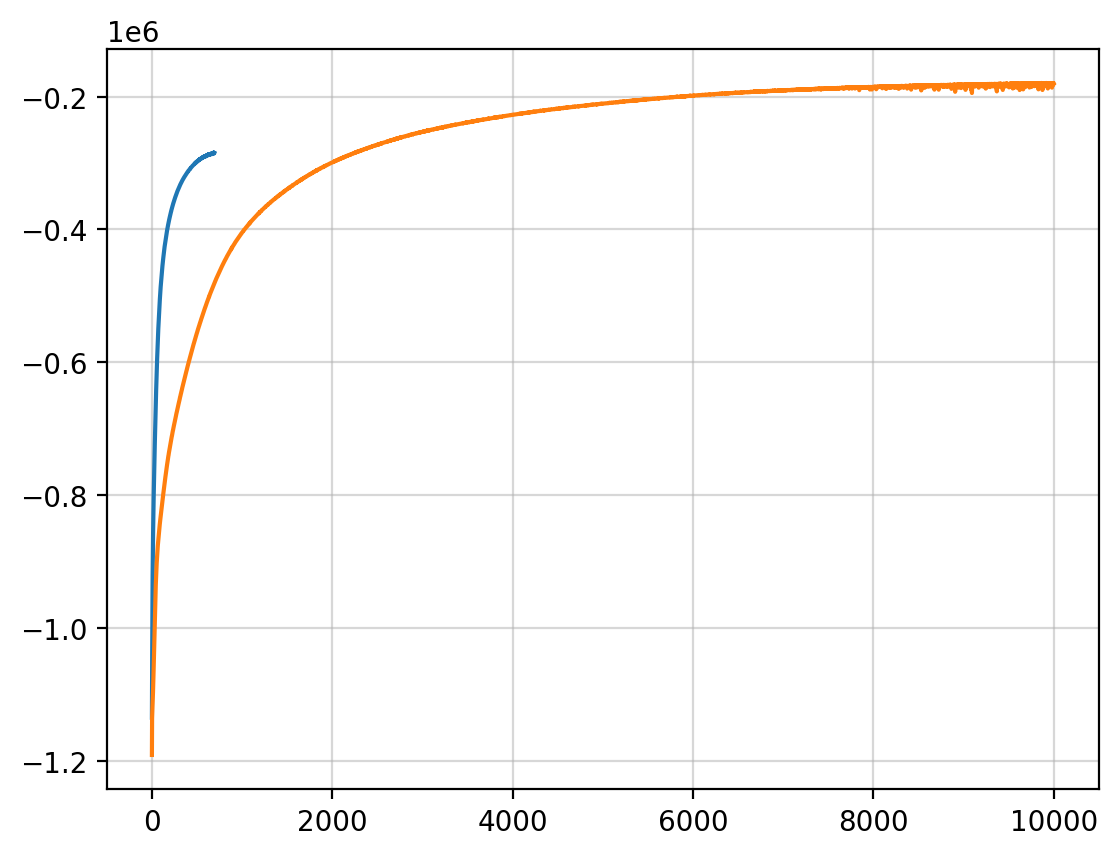

In [303]:
# 1e-3 - 31min 6s - 3 iterations
plt.plot(loss_hist)
plt.plot(hist_mll_vae)
plt.grid(alpha=0.5)

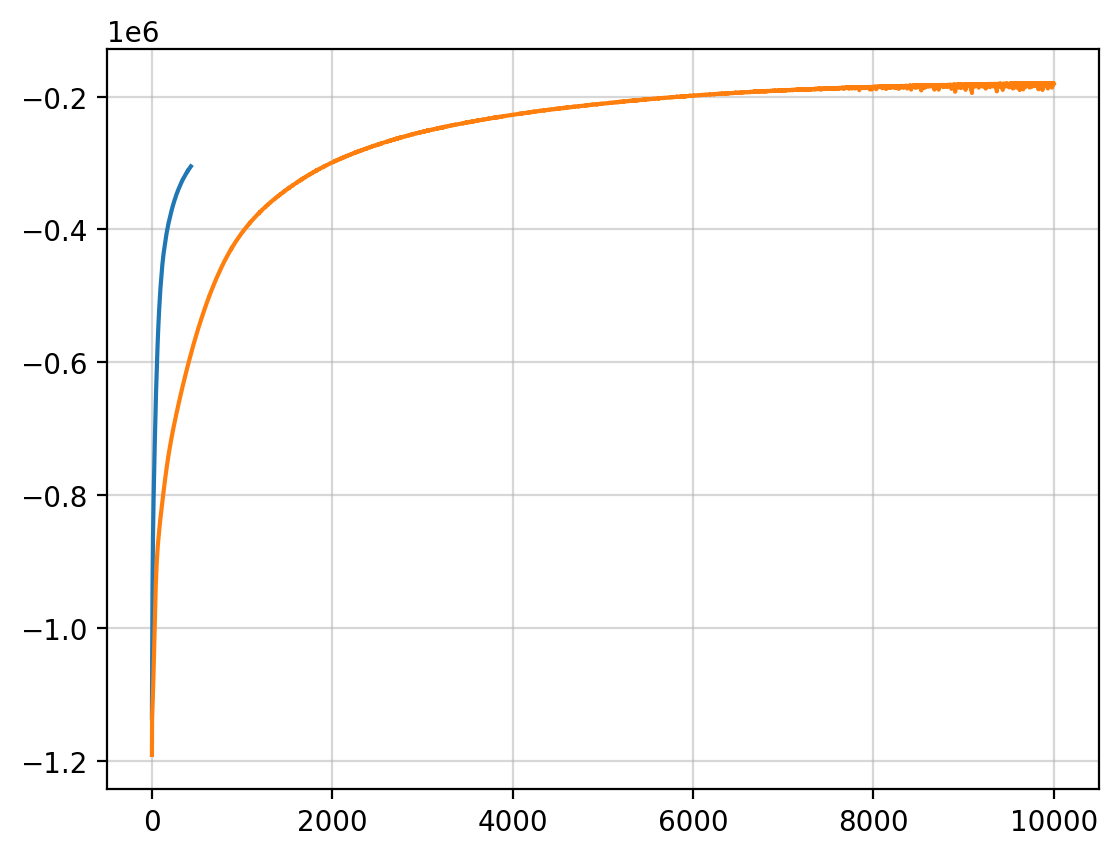

In [300]:
# 1e-4: 14min
plt.plot(loss_hist)
plt.plot(hist_mll_vae)
plt.grid(alpha=0.5)

## Analysing posterior samples

In [280]:
n_samples = 5
key_choice, keys_is = jax.random.split(key_vae)
keys_is = jax.random.split(keys_is, n_samples)

0.08650246
0.08650246
0.08650246
0.08650246
0.08650246


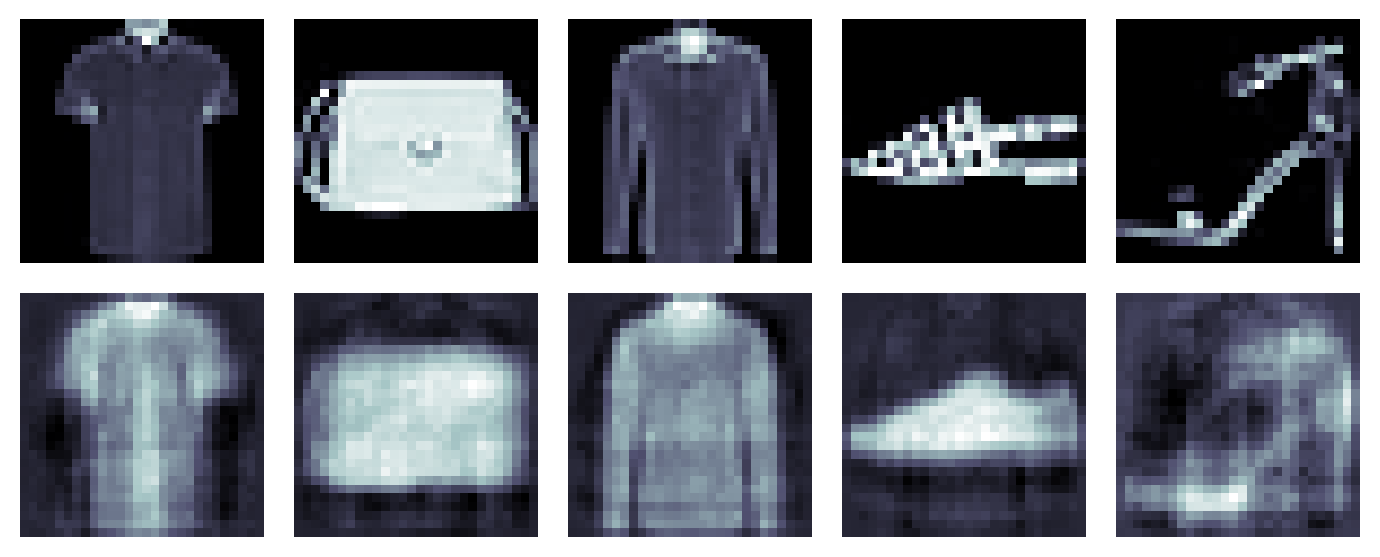

In [281]:

ixs_test = jax.random.choice(key_choice, len(samples_observed), (n_samples,))
fig, ax = plt.subplots(2, n_samples, figsize=(7, 3.0))

for ax, ix, key in zip(ax.T, ixs_test, keys_is):
    obs = samples_observed[ix]

    mu, Sigma = ipl_vae.estimate_posterior_params(obs, params_decoder)
    dist_posterior_latent = tfd.MultivariateNormalFullCovariance(mu, Sigma)
    is_samples = dist_posterior_latent.sample(seed=key, sample_shape=1)
    mean_x, logvar_x = ipl_vae.decoder.apply(params_decoder, is_samples)

    ax[0].imshow(obs.reshape(28, 28), cmap="bone")
    ax[1].imshow(mean_x.reshape(28, 28), cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
    maxdifff = jnp.sum(jnp.abs(jnp.tril(Sigma) - jnp.triu(Sigma).T))
    print(maxdifff)
plt.tight_layout()